In [1]:
path = 'Documents/Datasets/OC - Projet 7/' # main folder

# **Import packages**

In [2]:
# https://pypi.org/project/ipython-autotime/
install_autotime = !pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2022-07-29 19:10:29 +02:00)


In [3]:
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.base import clone

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import shap

time: 3.75 s (started: 2022-07-29 19:10:29 +02:00)


In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

time: 0 ns (started: 2022-07-29 19:10:33 +02:00)


# **Import data**

In [5]:
data = pd.read_parquet(path + 'data.parquet')
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
data.index = data['SK_ID_CURR']
data.drop('SK_ID_CURR', axis=1, inplace=True)
print(data.shape)
data.head()

(356251, 770)


,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Sentproposal_MAX,CC_NAME_CONTRACT_STATUS_Sentproposal_MEAN,CC_NAME_CONTRACT_STATUS_Sentproposal_SUM,CC_NAME_CONTRACT_STATUS_Sentproposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 3.39 s (started: 2022-07-29 19:10:33 +02:00)


In [6]:
test_data = data[data.TARGET.isna()]
print('test samples:', test_data.shape[0])

train_data = data[~data.TARGET.isna()]
train_data.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data.fillna(0, inplace=True)
print('train samples:', train_data.shape[0])

test samples: 48744
train samples: 307507
time: 3.7 s (started: 2022-07-29 19:10:36 +02:00)


In [7]:
y = train_data.TARGET
X = train_data.drop('TARGET', axis=1)
X_scaled = StandardScaler().fit_transform(X)

time: 10.3 s (started: 2022-07-29 19:10:40 +02:00)


In [8]:
def sample(X, y, sampling_size, stratified=False):
  X_sample = X.sample(sampling_size)
  y_sample = y.sample(sampling_size)

  original_distribution = round(y.value_counts() / y.shape[0], 2)
  sample_distribution = round(y_sample.value_counts() / y_sample.shape[0], 2)

  if stratified == True:
    if not sample_distribution.equals(original_distribution):
      return sample(X, y, sampling_size, stratified=True)
  
  print('Original distribution:')
  print(y.shape)
  print(original_distribution)

  print('_____________________________')
  print('Sample distribution:')
  print(y_sample.shape)
  print(sample_distribution)

  return X_sample, y_sample

time: 15 ms (started: 2022-07-29 19:10:50 +02:00)


# **Choix du meilleur modèle**

In [ ]:
estimators_and_parameters = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html?highlight=logisticregression#sklearn.linear_model.LogisticRegression
    LogisticRegression(class_weight='balanced', random_state=42): {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier
    SGDClassifier(class_weight='balanced', random_state=42): {
        'loss': ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    },

    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier
    RandomForestClassifier(class_weight='balanced', random_state=42): {
        'criterion': ['gini', 'entropy', 'log_loss'],
    },

    # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
    LGBMClassifier(class_weight='balanced', random_state=42): {
        'boosting_type': ['gbdt', 'dart', 'goss', 'rf', None],
    },
}

In [ ]:
scoring = ['roc_auc', 'precision', 'recall']
kf = StratifiedKFold(n_splits=5)

models = dict()
results = None
for estimator, param_grid in estimators_and_parameters.items():
  print('Fitting {}...'.format(str(estimator).split('(')[0]))

  model = GridSearchCV(estimator, param_grid, scoring=scoring, refit='roc_auc', cv=kf, verbose=2)
  model.fit(X_scaled, y)

  models[str(estimator).split('(')[0]] = model

  cv_results = pd.DataFrame(model.cv_results_)
  cv_results.index = [str(estimator).split('(')[0] for i in cv_results.index]
  cv_results.drop([col for col in cv_results.columns if col.startswith('param_')], axis=1, inplace=True)

  if results is None:
    results = pd.DataFrame(columns=cv_results.columns)
  
  results = results.append(cv_results)

results.sort_values(by=['mean_test_roc_auc', 'mean_fit_time'], ascending=[False, True], inplace=True)

In [ ]:
results[['params', 'mean_test_roc_auc', 'mean_test_precision', 'mean_test_recall', 'mean_fit_time']].head(10)

# **Fine-tuning du meilleur modèle**

In [ ]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
LGBMClassifier(
    learning_rate=0.1,
    n_estimators=10,
    objective='binary',
    class_weight='balanced',
    random_state=42,
    )

param_grid =  {
    'num_leaves': [10, 50, 100],
    'min_child_samples': [50, 100, 500],
    'reg_alpha': [0, 0.3, 0.7],
    'reg_lambda': [0, 0.3, 0.7],
    },

time: 0 ns (started: 2022-07-03 23:46:36 +02:00)


In [ ]:
scoring = ['roc_auc', 'precision', 'recall']
kf = StratifiedKFold(n_splits=5)

model = GridSearchCV(estimator, param_grid, scoring=scoring, refit='roc_auc', cv=kf, verbose=2)
model.fit(X_scaled, y)

cv_results = pd.DataFrame(model.cv_results_).sort_values(by=['mean_test_roc_auc', 'mean_fit_time'], ascending=[False, True])

In [ ]:
cv_results[[col for col in cv_results if col.startswith('param_') or col in ['mean_test_roc_auc', 'mean_test_precision', 'mean_test_recall', 'mean_fit_time']]].head(10)

,mean_fit_time,param_min_child_samples,param_num_leaves,param_reg_alpha,param_reg_lambda,mean_test_roc_auc,mean_test_precision,mean_test_recall
68,48.006687,500,50,0.3,0.7,0.784853,0.224979,0.588399
69,41.704292,500,50,0.7,0,0.784783,0.225192,0.585539
71,46.964711,500,50,0.7,0.7,0.784495,0.219066,0.595569
63,35.667838,500,50,0,0,0.784454,0.223198,0.586828
67,49.382970,500,50,0.3,0.3,0.784325,0.221473,0.594683
66,52.054695,500,50,0.3,0,0.784310,0.224497,0.591541
70,43.610166,500,50,0.7,0.3,0.784305,0.224624,0.586506
80,41.717566,500,100,0.7,0.7,0.784229,0.230562,0.559758
78,42.674598,500,100,0.7,0,0.784210,0.236885,0.552910
64,39.879244,500,50,0,0.3,0.784100,0.216895,0.604068


time: 16 ms (started: 2022-07-04 14:47:31 +02:00)


# **Fonction coût**

In [14]:
# Calcul du taux d'intérêt moyen
interest_rate_df = train_data[['APPROVED_AMT_CREDIT_MEAN', 'APPROVED_AMT_ANNUITY_MEAN', 'APPROVED_CNT_PAYMENT_MEAN']].copy()
interest_rate_df.rename({'APPROVED_AMT_CREDIT_MEAN':'AMT_CREDIT', 'APPROVED_AMT_ANNUITY_MEAN':'AMT_ANNUITY', 'APPROVED_CNT_PAYMENT_MEAN':'CNT_PAYMENT'}, axis=1, inplace=True)
interest_rate_df['AMT_REIMBURSED'] = interest_rate_df['AMT_ANNUITY'] * interest_rate_df['CNT_PAYMENT']
interest_rate_df['AMT_PROFITS'] = interest_rate_df['AMT_REIMBURSED'] - interest_rate_df['AMT_CREDIT']
interest_rate_df['INTEREST_RATE'] = interest_rate_df['AMT_PROFITS'] / interest_rate_df['AMT_CREDIT']
interest_rate_df.head()

,AMT_CREDIT,AMT_ANNUITY,CNT_PAYMENT,AMT_REIMBURSED,AMT_PROFITS,INTEREST_RATE
SK_ID_CURR,,,,,,
100002,179055.00,9251.775,24.000000,222042.60,42987.60,0.240080
100003,484191.00,56553.990,10.000000,565539.90,81348.90,0.168010
100004,20106.00,5357.250,4.000000,21429.00,1323.00,0.065801
100006,343728.90,21842.190,18.000000,393159.42,49430.52,0.143807
100007,166638.75,12278.805,20.666667,253761.97,87123.22,0.522827


time: 62 ms (started: 2022-07-29 16:37:15 +02:00)


In [15]:
# interest_rate: profits
average_interest_rate = interest_rate_df['INTEREST_RATE'].mean()
print('Hypothèse n°1 :')
print("Les bons clients remboursent leur prêt avec un taux d'intérêt moyen de {:.0%}.".format(average_interest_rate), '\n')

# default_rate: loss
average_default_rate = 0.7
print('Hypothèse n°2 :')
print("Les mauvais clients ne remboursent pas leur prêt à hauteur de {:.0%}.".format(average_default_rate))

Hypothèse n°1 :
Les bons clients remboursent leur prêt avec un taux d'intérêt moyen de 12%. 

Hypothèse n°2 :
Les mauvais clients ne remboursent pas leur prêt à hauteur de 70%.
time: 0 ns (started: 2022-07-29 16:37:16 +02:00)


In [16]:
def cost_function(y_true, y_pred, interest_rate, default_rate):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

  best_scenario = (tn + fp) * interest_rate - (tp + fn) * 0 # 100% de crédits accordés aux bons payeurs, 0% de crédit accordé aux mauvais payeurs
  overall_results = tn * interest_rate - fn * default_rate

  return overall_results / best_scenario

time: 0 ns (started: 2022-07-29 16:37:18 +02:00)


In [17]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
estimator = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=10,
    objective='binary',
    min_child_samples=500,
    num_leaves=50,
    reg_alpha=0.3,
    reg_lambda=0.7,
    random_state=42,
    )

scoring = make_scorer(cost_function, interest_rate=average_interest_rate, default_rate=average_default_rate)
kf = StratifiedKFold(n_splits=5)

time: 0 ns (started: 2022-07-29 16:37:29 +02:00)


In [21]:
param_grid =  {
    'class_weight': [None, 'balanced', {0:1, 1:2}, {0:1, 1:5}, {0:1, 1:10}, {0:1, 1:25}, {0:1, 1:50}, {0:1, 1:100}]
    },

model = GridSearchCV(estimator, param_grid, scoring=scoring, cv=kf, verbose=2)
model.fit(X_scaled, y)

cv_results = pd.DataFrame(model.cv_results_).sort_values(by=['mean_test_score', 'mean_fit_time'], ascending=[False, True])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ..................................class_weight=None; total time=  16.7s
[CV] END ..................................class_weight=None; total time=  15.1s
[CV] END ..................................class_weight=None; total time=  15.3s
[CV] END ..................................class_weight=None; total time=  15.0s
[CV] END ..................................class_weight=None; total time=  15.1s
[CV] END ..............................class_weight=balanced; total time=  16.3s
[CV] END ..............................class_weight=balanced; total time=  15.2s
[CV] END ..............................class_weight=balanced; total time=  15.3s
[CV] END ..............................class_weight=balanced; total time=  15.4s
[CV] END ..............................class_weight=balanced; total time=  15.6s
[CV] END ..........................class_weight={0: 1, 1: 2}; total time=  15.7s
[CV] END ..........................class_weight={

In [22]:
cv_results[[col for col in cv_results if col.startswith('param_') or col in ['mean_test_score', 'std_test_score', 'mean_fit_time']]].head(10)

,mean_fit_time,param_class_weight,mean_test_score,std_test_score
4,16.708888,"{0: 1, 1: 10}",0.546351,0.003731
3,16.344473,"{0: 1, 1: 5}",0.525847,0.001543
1,15.580278,balanced,0.518063,0.002040
0,15.462211,None,0.480854,0.000004
2,16.270442,"{0: 1, 1: 2}",0.480854,0.000004
5,15.714795,"{0: 1, 1: 25}",0.162524,0.001957
6,15.866027,"{0: 1, 1: 50}",0.021597,0.001479
7,15.510351,"{0: 1, 1: 100}",0.015530,0.002625


time: 32 ms (started: 2022-07-29 17:27:48 +02:00)


In [23]:
# Fine-tuning
param_grid =  {
    'class_weight': [{0:1, 1:5}, {0:1, 1:7}, {0:1, 1:10}, {0:1, 1:12}, {0:1, 1:15}]
    },

model = GridSearchCV(estimator, param_grid, scoring=scoring, cv=kf, verbose=2)
model.fit(X_scaled, y)

cv_results = pd.DataFrame(model.cv_results_).sort_values(by=['mean_test_score', 'mean_fit_time'], ascending=[False, True])

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........................class_weight={0: 1, 1: 5}; total time=  14.3s
[CV] END ..........................class_weight={0: 1, 1: 5}; total time=  13.4s
[CV] END ..........................class_weight={0: 1, 1: 5}; total time=  12.9s
[CV] END ..........................class_weight={0: 1, 1: 5}; total time=  13.2s
[CV] END ..........................class_weight={0: 1, 1: 5}; total time=  12.9s
[CV] END ..........................class_weight={0: 1, 1: 7}; total time=  14.1s
[CV] END ..........................class_weight={0: 1, 1: 7}; total time=  14.3s
[CV] END ..........................class_weight={0: 1, 1: 7}; total time=  15.7s
[CV] END ..........................class_weight={0: 1, 1: 7}; total time=  13.1s
[CV] END ..........................class_weight={0: 1, 1: 7}; total time=  12.1s
[CV] END .........................class_weight={0: 1, 1: 10}; total time=  13.6s
[CV] END .........................class_weight={0

In [24]:
cv_results[[col for col in cv_results if col.startswith('param_') or col in ['mean_test_score', 'std_test_score', 'mean_fit_time']]].head(10)

,mean_fit_time,param_class_weight,mean_test_score,std_test_score
1,13.901114,"{0: 1, 1: 7}",0.563489,0.003410
2,13.464343,"{0: 1, 1: 10}",0.546351,0.003731
0,13.386548,"{0: 1, 1: 5}",0.525847,0.001543
3,13.529161,"{0: 1, 1: 12}",0.502867,0.003372
4,12.711054,"{0: 1, 1: 15}",0.412541,0.001866


time: 16 ms (started: 2022-07-29 17:34:46 +02:00)


# **Modèle final**

In [25]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
final_model = LGBMClassifier(
    learning_rate=0.01,
    n_estimators=100,
    objective='binary',
    min_child_samples=500,
    num_leaves=50,
    reg_alpha=0.3,
    reg_lambda=0.7,
    class_weight={0:1, 1:7},
    random_state=42,
    )

time: 0 ns (started: 2022-07-29 17:35:23 +02:00)


In [26]:
final_model.fit(X_scaled, y)

LGBMClassifier(class_weight={0: 1, 1: 7}, learning_rate=0.01,
               min_child_samples=500, num_leaves=50, objective='binary',
               random_state=42, reg_alpha=0.3, reg_lambda=0.7)

time: 38.3 s (started: 2022-07-29 17:35:26 +02:00)


In [27]:
pickle.dump(final_model, open(path + 'model.pickle', 'wb'))

time: 16 ms (started: 2022-07-29 17:37:48 +02:00)


# **Feature importance**

In [9]:
loaded_model = pickle.load(open(path + 'model.pickle', 'rb'))

time: 47 ms (started: 2022-07-29 19:10:50 +02:00)


In [10]:
desc_df = pd.read_csv(path + 'data/' + 'HomeCredit_columns_description.csv', encoding_errors='replace')
desc_df['Row New'] = desc_df['Row'].apply(lambda x: pd.DataFrame(X.columns)[X.columns.str.contains(x)][0].tolist())

time: 235 ms (started: 2022-07-29 19:10:50 +02:00)


In [11]:
def get_desc(x):
  desc = list()
  for i in desc_df.index:
    if x in desc_df['Row New'][i]:
      desc.append(desc_df['Description'][i])
  return desc

time: 0 ns (started: 2022-07-29 19:10:51 +02:00)


In [49]:
# SHAP
explainer = shap.TreeExplainer(loaded_model)
shap_values = explainer.shap_values(X_scaled)
shap_values = pd.DataFrame(shap_values[0], index=X.index, columns=X.columns)

time: 1min 25s (started: 2022-07-29 19:29:11 +02:00)


In [55]:
# global feature importance df
gfi = pd.DataFrame({'feature_name':X.columns, 'feature_importance':shap_values.abs().mean()})
gfi['feature_description'] = gfi['feature_name'].apply(get_desc)
gfi.sort_values(by='feature_importance', ascending=False, inplace=True)

gfi.head(10)

,feature_name,feature_importance,feature_description
EXT_SOURCE_3,EXT_SOURCE_3,0.235104,[Normalized score from external data source]
EXT_SOURCE_2,EXT_SOURCE_2,0.209870,[Normalized score from external data source]
EXT_SOURCE_1,EXT_SOURCE_1,0.067621,[Normalized score from external data source]
DAYS_BIRTH,DAYS_BIRTH,0.039539,[Client's age in days at the time of application]
INSTAL_DPD_MEAN,INSTAL_DPD_MEAN,0.039243,[]
CODE_GENDER,CODE_GENDER,0.026939,[Gender of the client]
PREV_NAME_CONTRACT_STATUS_Refused_MEAN,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,0.020571,[Status of Credit Bureau loan during the month...
NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Highereducation,0.017249,[Level of highest education the client achieved]
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.015930,[Number of drawings at ATM during this month o...
PAYMENT_RATE,PAYMENT_RATE,0.012583,[]


time: 4.7 s (started: 2022-07-29 19:32:48 +02:00)


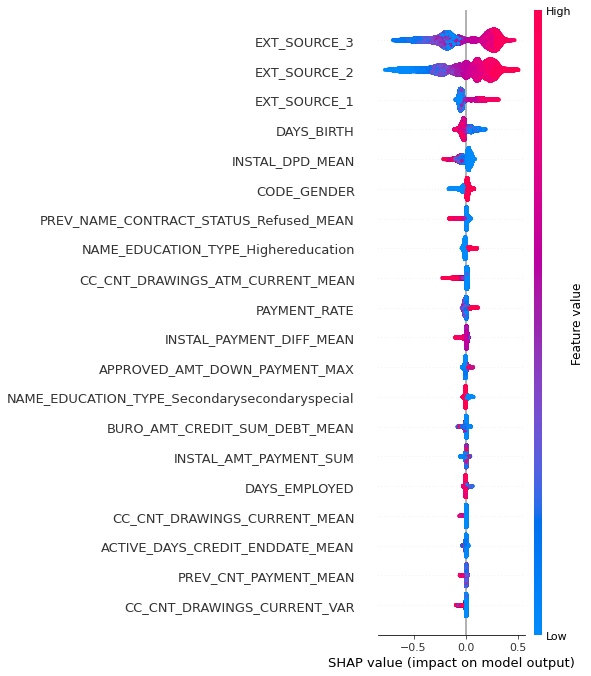

time: 46.1 s (started: 2022-07-29 19:35:24 +02:00)


In [62]:
# global feature importance plot
shap.summary_plot(shap_values.values, features=X_scaled, feature_names=X.columns)

In [131]:
# local feature importance df
idx = np.random.choice(X.index)

lfi = pd.DataFrame({'feature_name':X.columns, 'feature_importance':shap_values.loc[idx].tolist()})
lfi['client_value'] = X.loc[idx].tolist()
lfi['feature_description'] = lfi['feature_name'].apply(get_desc)
lfi.sort_values(by='feature_importance', ascending=False, key=abs, inplace=True)

print('Client n°{}:'.format(idx))
print('Probabilité de remboursement:', round(loaded_model.predict_proba(pd.DataFrame(X_scaled, index=X.index).loc[[idx]])[0][0], 2))
print('Crédit', 'accordé.' if loaded_model.predict(pd.DataFrame(X_scaled, index=X.index).loc[[idx]]) == 0 else 'refusé.')

lfi.head(10)

Client n°337255:
Probabilité de remboursement: 0.59
Crédit accordé.


,feature_name,feature_importance,client_value,feature_description
32,EXT_SOURCE_3,-0.186332,0.000000,[Normalized score from external data source]
31,EXT_SOURCE_2,-0.120319,0.420531,[Normalized score from external data source]
244,PAYMENT_RATE,0.064788,0.107692,[]
30,EXT_SOURCE_1,-0.057092,0.000000,[Normalized score from external data source]
9,DAYS_BIRTH,-0.052849,-8874.000000,[Client's age in days at the time of application]
609,INSTAL_DPD_MEAN,0.038782,0.000000,[]
0,CODE_GENDER,0.027993,1.000000,[Gender of the client]
427,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,0.025906,0.000000,[Status of Credit Bureau loan during the month...
125,NAME_EDUCATION_TYPE_Highereducation,-0.016566,0.000000,[Level of highest education the client achieved]
619,INSTAL_PAYMENT_DIFF_MEAN,0.016262,0.000000,[]


time: 828 ms (started: 2022-07-29 19:51:15 +02:00)


In [132]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values.loc[idx].values, features=pd.DataFrame(X_scaled, index=X.index).loc[idx], feature_names=X.columns)

time: 16 ms (started: 2022-07-29 19:51:16 +02:00)


# **Test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

time: 4.62 s (started: 2022-07-07 15:56:38 +02:00)


In [ ]:
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
estimator = clone(model.best_estimator_)

time: 0 ns (started: 2022-07-07 15:56:42 +02:00)


In [ ]:
estimator.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 1, 1: 7}, min_child_samples=500,
               n_estimators=10, num_leaves=50, objective='binary',
               random_state=42, reg_alpha=0.3, reg_lambda=0.7)

time: 12.1 s (started: 2022-07-07 15:56:42 +02:00)


In [ ]:
y_pred = estimator.predict(X_test)

time: 62 ms (started: 2022-07-07 15:56:55 +02:00)


In [ ]:
print('custom_score:', round(cost_function(y_test, y_pred, interest_rate=average_interest_rate, default_rate=average_default_rate), 2))

print('roc_auc:', round(roc_auc_score(y_test, y_pred), 2))
print('precision:', round(precision_score(y_test, y_pred), 2))
print('recall:', round(recall_score(y_test, y_pred), 2))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
print()
print('True Negative: ', tn)
print('False Positive:', fp)
print('_______________')
print('True Positive: ', tp)
print('False Negative:', fn)

custom_score: 0.56
roc_auc: 0.62
precision: 0.25
recall: 0.34

True Negative:  64343
False Positive: 6281
_______________
True Positive:  2101
False Negative: 4152
time: 94 ms (started: 2022-07-07 15:56:55 +02:00)
